In [1]:
%matplotlib widget
#replace with inline if problems are encountered

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import ncempy
import h5py

import stempy.io as stio
import stempy.image as stim

# Load data from Josh's output

In [2]:
file_path = Path('/global/homes/j/jrenner1/occupancy/counted_halo_scan0000000159.h5')

with h5py.File(file_path, 'r') as f0:
    for k,v in f0['electron_events'].items():
        print(k,v)
        
    events = f0['electron_events/frames'][:]
    weights = f0['electron_events/weights'][:]

frames <HDF5 dataset "frames": shape (1049600,), type "|O">
scan_positions <HDF5 dataset "scan_positions": shape (1049600,), type "<i8">
weights <HDF5 dataset "weights": shape (1049600,), type "|O">


In [3]:
file_path = Path('/pscratch/sd/j/jrenner1/counted_halo_gauss_prior_scan0000000159.h5')

with h5py.File(file_path, 'r') as f0:
    for k,v in f0['electron_events'].items():
        print(k,v)
        
    events_prior = f0['electron_events/frames'][:]
    weights_prior = f0['electron_events/weights'][:]

frames <HDF5 dataset "frames": shape (1049600,), type "|O">
weights <HDF5 dataset "weights": shape (1049600,), type "|O">


# Load standard counting data

In [4]:
file_path = Path('FOURD_240509_1311_16228_00159.h5')

with h5py.File(file_path, 'r') as f0:
    for k,v in f0['electron_events'].items():
        print(k,v)
        
    events_standard = f0['electron_events/frames'][:]

frames <HDF5 dataset "frames": shape (1049600,), type "|O">
scan_positions <HDF5 dataset "scan_positions": shape (1049600,), type "<i8">


# Create a single frame diffraction pattern (dp)
 - Add the weight at each electron location for the `dp_weights` and `dp_prior` images
 - Add only one electron at each location for the `dp_events` image

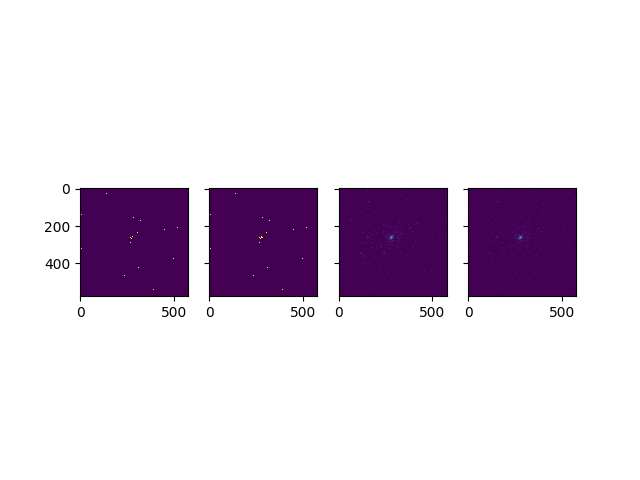

In [5]:
# Create a DP from a single frame
dp_prior = np.zeros((576*576), dtype=np.int32) # diffraction pattern with weights
dp_weights = np.zeros((576*576), dtype=np.int32) # diffraction pattern with weights
dp_events = np.zeros((576*576), dtype=np.int32) # diffractin patterh with only 1 electron per pixel
dp_events_standard = np.zeros((576*576), dtype=np.int32)

# Put weight value at each electron position
choose_dp = 6000 # choose a probe position 
for ev, w in zip(events[choose_dp], weights[choose_dp]):
    dp_weights[ev] += w
for ev, w in zip(events_prior[choose_dp], weights_prior[choose_dp]):
    dp_prior[ev] += w
    
# add 1 electron for each position
dp_events[events[choose_dp]] += 1
dp_events_standard[events_standard[choose_dp]] += 1

dp_prior = dp_prior.reshape((576, 576))
dp_weights = dp_weights.reshape((576, 576))
dp_events = dp_events.reshape((576, 576))
dp_events_standard = dp_events_standard.reshape((576, 576))

# Plot the results together. Add 0.1 to avoid log(0)
fg,ax = plt.subplots(1, 4, sharex=True, sharey=True)
ax[0].imshow(dp_events_standard + 0.1, norm=LogNorm(vmin=0.1), interpolation='none')
ax[1].imshow(dp_events + 0.1, norm=LogNorm(vmin=0.1), interpolation='none')
ax[2].imshow(dp_weights + 0.1, norm=LogNorm(vmin=0.1))
ax[3].imshow(dp_prior + 0.1, norm=LogNorm(vmin=0.1))

# Sum all diffraciton patterns

## Sum all patterns with weights
 - each electron strike location has to be indexed separately making this very slow

CPU times: user 2min 7s, sys: 0 ns, total: 2min 7s
Wall time: 2min 7s


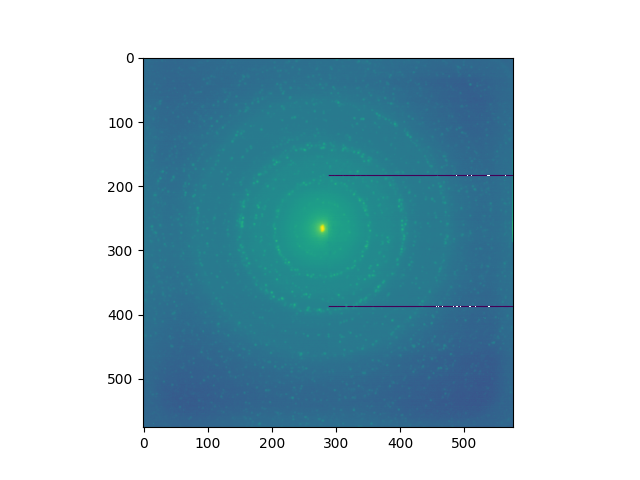

In [6]:
%%time
full_sum_dp = np.zeros((576*576), dtype=np.int32) # 

# Loop over all frames
for frame_ev, frame_w in zip(events[0:], weights[0:]):
    # Loop over each electron event and add the weight at the correct location
    # This is slow but I dont know how to speed this up
    for ev, w in zip(frame_ev, frame_w):
        full_sum_dp[ev] += w
full_sum_dp = full_sum_dp.reshape((576, 576))

fg, ax = plt.subplots(1,1)
ax.imshow(full_sum_dp, norm=LogNorm())

## Sum all patterns with weights + prior
 - each electron strike location has to be indexed separately making this very slow

CPU times: user 12min 52s, sys: 21.3 ms, total: 12min 52s
Wall time: 12min 52s


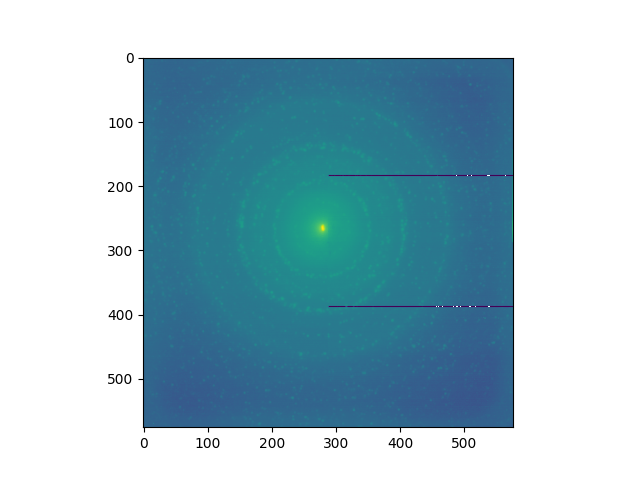

In [7]:
%%time
full_sum_dp_prior = np.zeros((576*576), dtype=np.int32) # 

# Loop over all frames
for frame_ev, frame_w in zip(events_prior[0:], weights_prior[0:]):
    # Loop over each electron event and add the weight at the correct location
    # This is slow but I dont know how to speed this up
    for ev, w in zip(frame_ev, frame_w):
        full_sum_dp_prior[ev] += w
full_sum_dp_prior = full_sum_dp_prior.reshape((576, 576))

fg, ax = plt.subplots(1,1)
ax.imshow(full_sum_dp_prior, norm=LogNorm())

## Sum all patterns placing 1 electron per strike
 - this is faster because we can use numpy "fancy indexing" and assume 1 electron per strike

CPU times: user 6.97 s, sys: 68 ms, total: 7.04 s
Wall time: 6.95 s


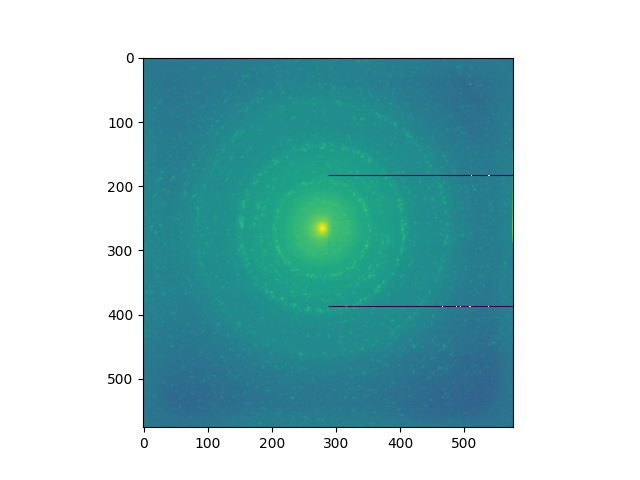

In [8]:
%%time
full_sum_dp_events = np.zeros((576*576), dtype=np.uint32) # 
# Loop over all frames
for frame_ev in events:
    full_sum_dp_events[frame_ev] += 1 # numpy does the "fancy indexing"
full_sum_dp_events = full_sum_dp_events.reshape((576, 576))

fg, ax = plt.subplots(1, 1)
ax.imshow(full_sum_dp_events, norm=LogNorm());

## Sum all standard patterns placing 1 electron per strike

CPU times: user 6.81 s, sys: 52.1 ms, total: 6.87 s
Wall time: 6.8 s


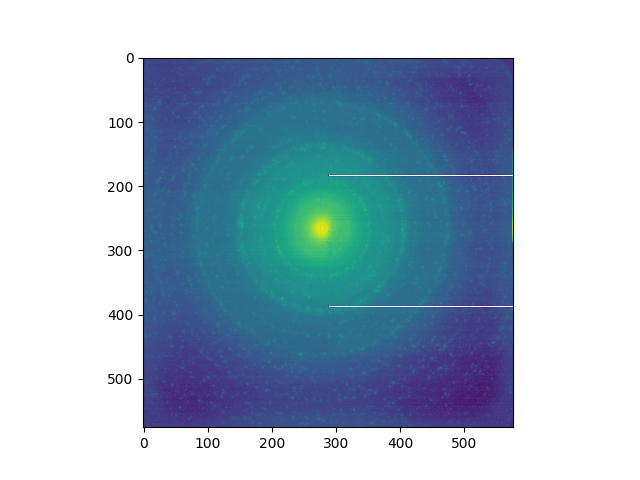

In [9]:
%%time
full_sum_dp_events_standard = np.zeros((576*576), dtype=np.uint32) # 

# Loop over all frames
for frame_ev in events_standard:
    full_sum_dp_events_standard[frame_ev] += 1 # numpy does the "fancy indexing"
full_sum_dp_events_standard = full_sum_dp_events_standard.reshape((576, 576))

fg, ax = plt.subplots(1, 1)
ax.imshow(full_sum_dp_events_standard, norm=LogNorm());

## Plot the weighted and non-weighted DPs together

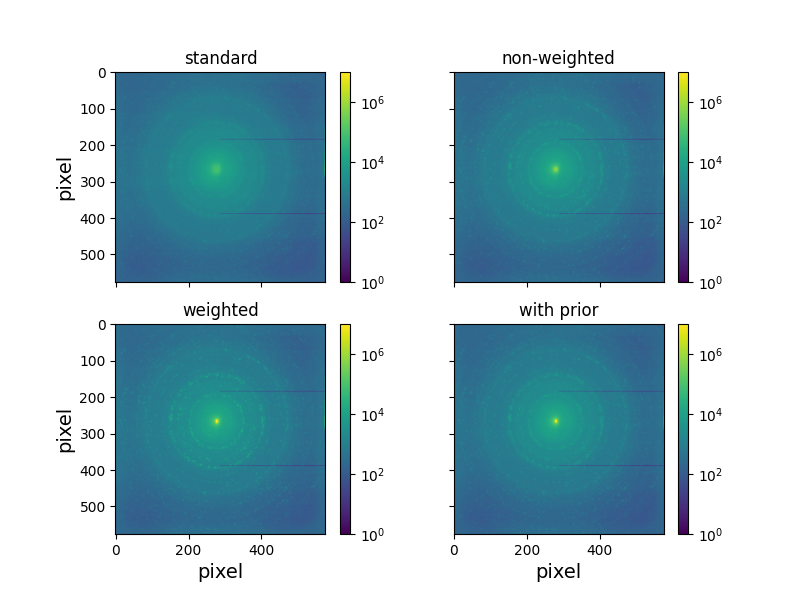

In [15]:
fg, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8,6))#figsize=(16,3))
ax = axes.flatten()
imax0 = ax[0].imshow(full_sum_dp_events_standard, norm=LogNorm(vmin=1, vmax=1e7))
imax1 = ax[1].imshow(full_sum_dp_events, norm=LogNorm(vmin=1, vmax=1e7))
imax2 = ax[2].imshow(full_sum_dp, norm=LogNorm(vmin=1, vmax=1e7))
imax3 = ax[3].imshow(full_sum_dp_prior, norm=LogNorm(vmin=1, vmax=1e7))
ax[0].set(title='standard')
ax[0].set_ylabel('pixel',fontsize=14)
ax[1].set(title='non-weighted')
ax[2].set(title='weighted')
ax[2].set_xlabel('pixel',fontsize=14)
ax[2].set_ylabel('pixel',fontsize=14)
ax[3].set(title='with prior')
ax[3].set_xlabel('pixel',fontsize=14)
# imax0 = ax[0].imshow(full_sum_dp, nor, norm=LogNorm())
fg.colorbar(imax0, ax=ax[0])
fg.colorbar(imax1, ax=ax[1])
fg.colorbar(imax2, ax=ax[2])
fg.colorbar(imax3, ax=ax[3])
plt.savefig("fig_counting.pdf",bbox_inches='tight')